In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import math

In [2]:
data = pd.read_excel('horner-plot.xls', names=['t', 'p'], skiprows=3)
data = data.reset_index(drop=True)

t = data['t']
p = data['p']

In [3]:
dx_r = np.zeros(len(t));
dx_l = np.zeros(len(t));

derivative_p = np.zeros(len(t));
 
for i in range(1, len(t) - 2):
    dx_r[i] = t[i + 2] - t[i + 1]

for i in range(2, len(t)):
    dx_l[i] = t[i - 1] - t[i]

for i in range(2, len(t) - 1):
    derivative_p[i] = ( dx_l[i] ** 2 * p[i + 1] - dx_r[i - 1] ** 2 * p[i - 1] - p[i] * (dx_l[i] ** 2 - 
                        dx_r[i - 1]  ** 2) ) / ( dx_l[i] ** 2 * dx_r[i - 1] - dx_l[i] ** 2 * dx_r[i - 1] ** 2)


In [4]:
derivative_p[8]

-1.4131109907644177

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


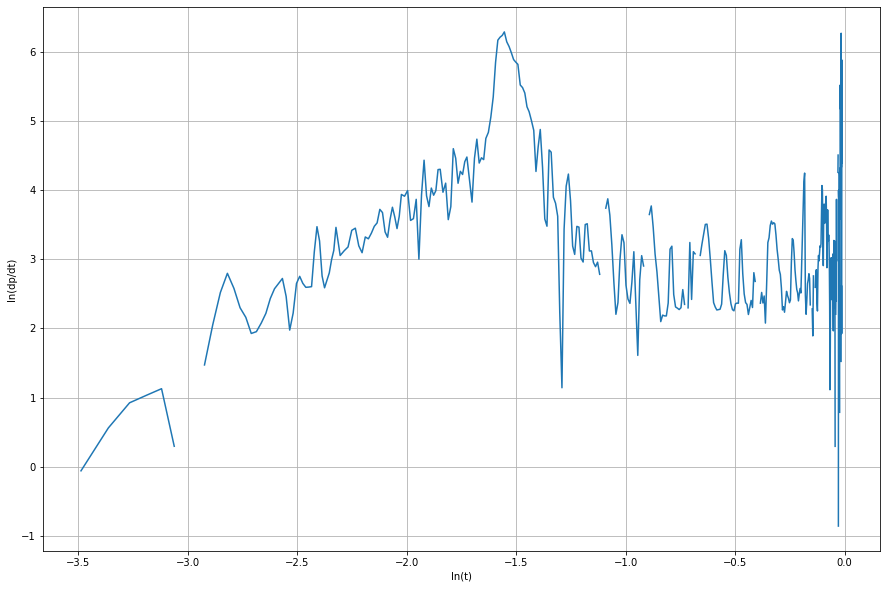

In [5]:
# график производной давления
plt.figure(figsize=(15, 10))
plt.plot(t, np.log(derivative_p))
plt.ylabel('ln(dp/dt)')
plt.xlabel('ln(t)')
plt.grid()
#plt.show()

**Построение тренда**

In [6]:
# для поиска линейного тренда выберем интервал времени [-1.184985; -0.176326]
t = t[144:288]
p = p[144:288]

In [7]:
x = np.matrix([np.ones(len(t)), t]).T
y = np.matrix(p).T

n, m = x.shape

In [8]:
# построим тренд с помощью мнк
beta = inv(x.T * x) * x.T * y
eps = y - x * beta
sigma = eps.T * eps / (n - m)

print('Коэффициенты регрессии: {}, {}'.format(beta[0, 0], beta[1, 0]))

Коэффициенты регрессии: 256.399031593553, 7.087121135251527


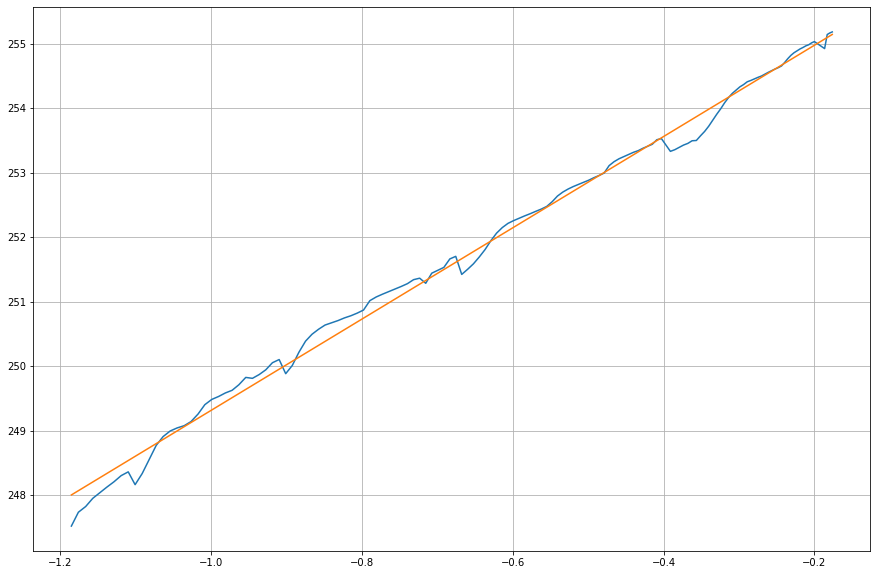

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(t, p, t, x.dot(beta))
plt.grid()

**Рассчет проницаемости**

По формуле   $k = \frac{B \cdot Q \cdot \mu}{4 \cdot \pi \cdot h \cdot tg(\alpha)}$ находим проницаемость.

In [10]:
# объемный коэф
B = 1.1

# м^3 / cек
Q = 150 / (24 * 3600)

# Пз
mu = 1.8e-3

# м
h = 1.8

# перевод в паскали
tg_alpha = beta[1, 0] * 10 ** 5

k = lambda x: B * Q * mu / (4 * math.pi * h * x) / 1.02e-12
print('Проницаемость - {} Дарси'.format(k(tg_alpha)))

Проницаемость - 0.2102278796399246 Дарси


**Построение доверительных интервалов.**

Остаточная сумма квадратов: 
$S = \epsilon^T \epsilon$, где $\epsilon$
– остатки.
Оценка дисперсии: 
$\hat{\sigma}^2 = \frac{S}{n - m}$, где $n$ - кол-во экспериментов, а $m$ - кол-во регрессоров.
Для поиска доверительного интервала коэффициента $\beta_{j}$ воспользуемся соотношением
$ \frac{ \hat{\beta_{j}} - \beta_{j} }{\sqrt{c_{jj}}}  \in t(n - m) $, где $c_{jj}$ - элемент матрицы $\hat{\sigma}^2 \cdot (X^TX)^{-1}$, стоящий на диагонали на пересечении строки и столбца $jj$, а $t$ - распределние Стьюдента.
Следовательно, $\gamma$ - доверительный интервал имеет вид
$\hat{\beta_{j}} = \beta_{j} \pm t_{\gamma}(n - m) \sqrt{c_{jj}}$.


In [11]:
from scipy.stats import t as st
import math

# уровень доверия 90%
alpha = 0.1

c = sigma[0, 0] * inv(x.T * x)
title = ['Пластового давления', 'Коэф тренда']

permeability_l = 0
permeability_r = 0

for idx, coef in enumerate(beta):
    delta = st.ppf(1 - alpha / 2, n - m) * math.sqrt(c[idx, idx])
    if idx == 1:
        permeability_l = k( (coef[0, 0] - delta) * 10 ** 5)
        permeability_r = k( (coef[0, 0] + delta) * 10 ** 5)

    print('Доверительный интервал для {}:'.format(title[idx]), end=' ')
    print('[{}, {}]'.format( (coef - delta)[0, 0], (coef + delta)[0, 0] ))

print('Доверительный интервал для Проницаемости: [{}, {}]'.format(permeability_r, permeability_l))

Доверительный интервал для Пластового давления: [256.3496160396325, 256.4484471474735]
Доверительный интервал для Коэф тренда: [7.0144264025773735, 7.159815867925681]
Доверительный интервал для Проницаемости: [0.2080934030286558, 0.21240659798893502]
